<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bias and Variance

_Authors: Joseph Nelson (DC), Kevin Markham (DC)_

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline

## Demo

Recall our basic Ames housing data linear regression model.

In [3]:
import pandas as pd

In [4]:
ames_df = pd.read_csv('../assets/data/ames_train.csv')

In [5]:
# To get us started, use just the numeric columns without missing data
ames_df = ames_df.select_dtypes(['int64', 'float64']).dropna(axis='columns')

In [6]:
# Split the data into the column `y` we want to predict and the 
# columns `X` we will use to make the predictions
X = ames_df.drop('SalePrice', axis='columns')
y = ames_df.loc[:, 'SalePrice']

In [7]:
# Set aside 25% of the data for testing the model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

In [8]:
# Import a model class
from sklearn.linear_model import LinearRegression

# Create a model from that class
lr = LinearRegression()

# Ask the model to learn a function that predicts `y` from `X`
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

This time, let's see how it does on both the training set and the test set.

In [ ]:
# Score the model on the test data
print('Training-set R^2:', lr.score(X_train, y_train))
print('Test-set R^2:', lr.score(X_test, y_test))

This model does well on the training set, substantially less well on the test set.

If we give the model fewer features to work with, then it will do worse on the training set, but the gap between its training-set performance and its test-set performance will be smaller.

In [9]:
feature_cols = ['OverallQual']
X = ames_df.loc[:, feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

lr = LinearRegression()

lr.fit(X_train, y_train)

print('Training-set R^2:', lr.score(X_train, y_train))
print('Test-set R^2:', lr.score(X_test, y_test))

Training-set R^2: 0.6216123082059799
Test-set R^2: 0.6341505060869193


By including a moderate number of highly relevant features, we can get better overall performance by choosing a model that does well on the training set and almost as well on the test set.

In [10]:
feature_cols = ['GarageCars',
                'GrLivArea',
                'OverallQual'
               ]
X = ames_df.loc[:, feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

lr = LinearRegression()

lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.7474755274012453
0.714416677626617


## Bias and Variance in Theory

Suppose we ran an animal shelter, and we wanted to build a model to predict adult dog weight from twelve-week puppy weight so that we could give people interested in adopting a puppy accurate information about how big they could expect each available puppy to become.

Suppose further that, as a matter of fact, the relationship between average adult dog weight and puppy weight for a particular breed follows a sigmoid (s-shaped) curve, like so:

In [12]:
def my_sigmoid(x):
    return 5 + 100 * np.exp(.4*(x-10)) / (1 + np.exp(.4*(x-10)))

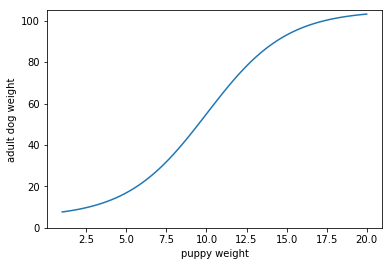

In [13]:
x = np.linspace(1, 20, 100).reshape(-1, 1)
y = my_sigmoid(x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_ylim(0, 105)
ax.set_xlabel('puppy weight')
ax.set_ylabel('adult dog weight');

Adult dog weight is not perfectly predictable from 12-week puppy weight, so actual data points don't fall on this line exactly. However, let's suppose that departures from this line are normally distributed, like so:

In [15]:
def generate_sigmoid_data(num_points):
    x_data = np.random.uniform(2, 18, num_points)
    y_data = my_sigmoid(x_data) + 4 * np.random.randn(*x_data.shape)
    return x_data.reshape(-1, 1), y_data

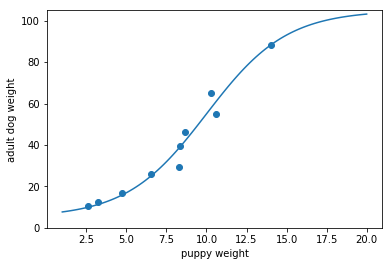

In [16]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.scatter(*generate_sigmoid_data(10))
ax.set_ylim(0, 105)
ax.set_xlabel('puppy weight')
ax.set_ylabel('adult dog weight');

Suppose that we fit a linear regression model to this data, like so:

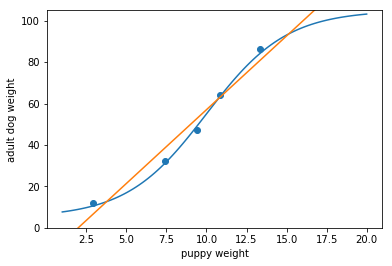

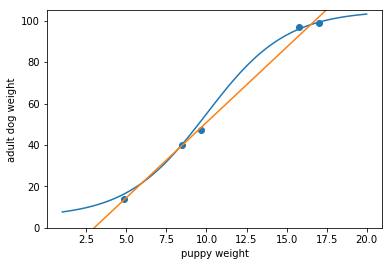

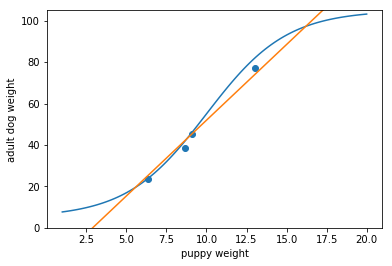

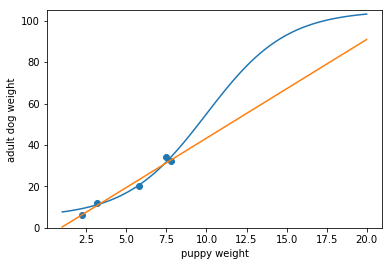

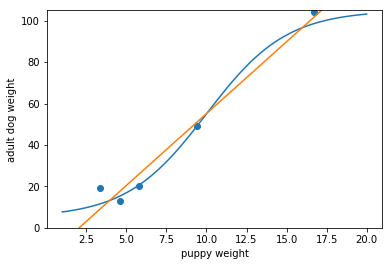

In [17]:
from sklearn.linear_model import LinearRegression

for trial in range(5):
    lr = LinearRegression()
    x_data, y_data = generate_sigmoid_data(5)
    lr.fit(x_data, y_data)
    predictions = lr.predict(x)

    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.scatter(x_data, y_data)
    ax.plot(x, predictions)
    ax.set_ylim(0, 105)
    ax.set_xlabel('puppy weight')
    ax.set_ylabel('adult dog weight')
    plt.show();

When we use our model to predict adult dog weights from new puppy weights, its prediction will not be perfect for three reasons:

1. **Irreducible error:** Even the true sigmoid curve does not make perfect predictions because adult dog weight is not perfectly predictable from puppy weight alone.
2. **Bias:** Our model is looking for a straight line when the true relationship is sigmoidal. The more data we collect, the better we will be able to estimate the best linear model, but even the best linear model will have more error than the true sigmoid curve.
3. **Variance:** We have a finite amount of data, so the model we produce will have more error than the best linear model.

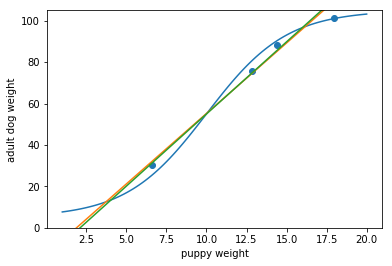

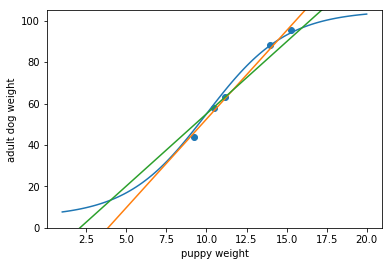

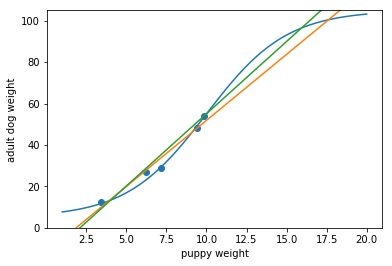

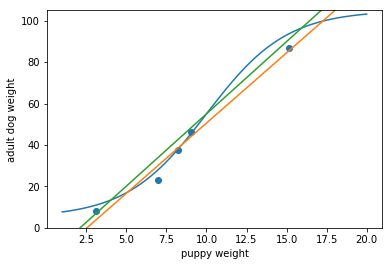

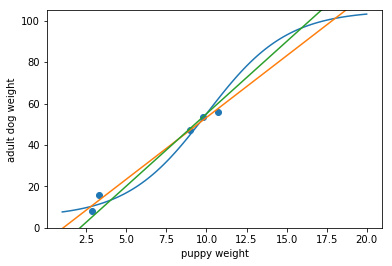

In [18]:
from sklearn.linear_model import LinearRegression

for trial in range(5):
    x_data, y_data = generate_sigmoid_data(5)
    lr = LinearRegression()
    lr.fit(x_data, y_data)
    predictions = lr.predict(x)

    x_data_large, y_data_large = generate_sigmoid_data(10_000)
    lr_large = LinearRegression()
    lr_large.fit(x_data_large, y_data_large)
    predictions_large = lr_large.predict(x)

    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.scatter(x_data, y_data)
    ax.plot(x, predictions)
    ax.plot(x, predictions_large)
    ax.set_ylim(0, 105)
    ax.set_xlabel('puppy weight')
    ax.set_ylabel('adult dog weight');

In this figure...

- **Irreducible error** manifests as the difference between each point and the blue curve.
- The **bias** of our linear model manifests as the difference between the green line (approximately the best linear model) and the blue curve.
- The **variance** of our linear model manifests as the differences between the orange lines and the green curve.

If we make our model more flexible, for instance by including puppy weight *squared* and *cubed* as additional features, then...

- **Irreducible error** (average difference between the true model and the data) remains the same. (The only way to reduce irreducible error is to get new features that are not merely functions of existing features.)
- **Bias** (average difference between the true model and the green curve, approximately) can only go down: our model is no longer restricted to being a straight line, so its ability to match the sigmoid curve can only improve, given enough data.
- **Variance** (fluctuations of the orange curve around the green curve) goes up: the more complex the model, the less well we can estimate it given a fixed sample size.

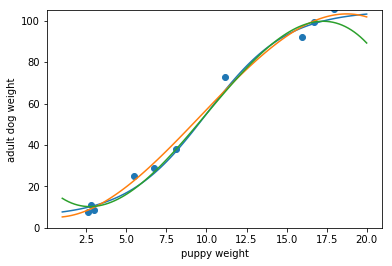

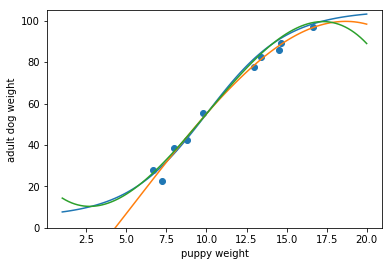

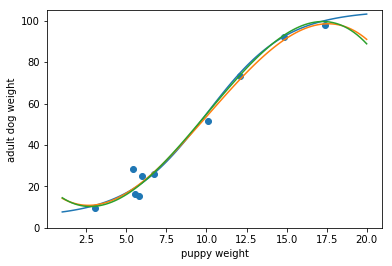

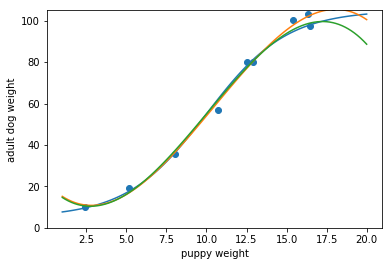

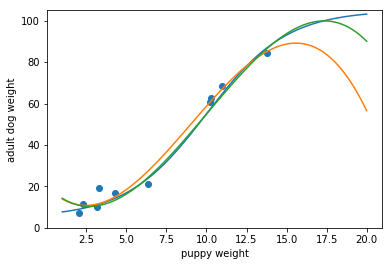

In [19]:
from sklearn.linear_model import LinearRegression

for trial in range(5):
    x_data, y_data = generate_sigmoid_data(10)
    X_data = np.hstack([x_data, x_data**2, x_data**3])

    lr = LinearRegression()
    lr.fit(X_data, y_data)
    predictions = lr.predict(np.hstack([x, x**2, x**3]))


    x_data_large, y_data_large = generate_sigmoid_data(10_000)
    X_data_large = np.hstack([x_data_large, x_data_large**2, x_data_large**3])

    lr_large = LinearRegression()
    lr_large.fit(X_data_large, y_data_large)
    predictions_large = lr_large.predict(np.hstack([x, x**2, x**3]))


    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.scatter(x_data, y_data)
    ax.plot(x, predictions)
    ax.plot(x, predictions_large)
    ax.set_ylim(0, 105)
    ax.set_xlabel('puppy weight')
    ax.set_ylabel('adult dog weight');

Let's see what happens when we push model complexity too far.

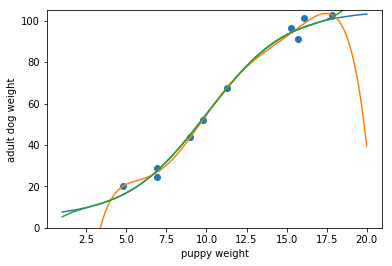

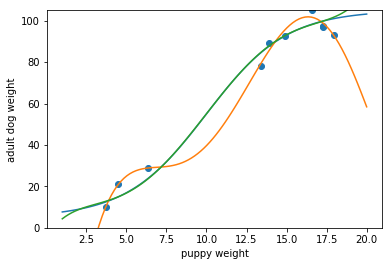

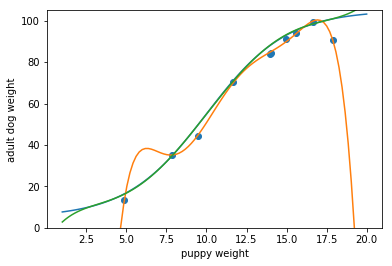

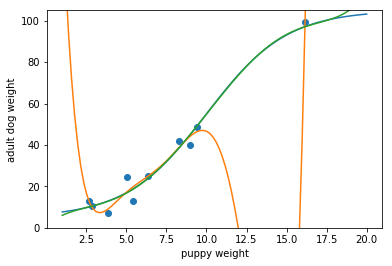

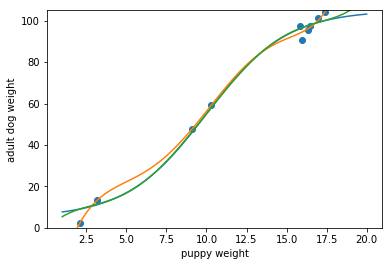

In [20]:
from sklearn.linear_model import LinearRegression

for trial in range(5):
    x_data, y_data = generate_sigmoid_data(10)
    X_data = np.hstack([x_data, x_data**2, x_data**3, x_data**4, x_data**5, x_data**6])

    lr = LinearRegression()
    lr.fit(X_data, y_data)
    predictions = lr.predict(np.hstack([x, x**2, x**3, x**4, x**5, x**6]))


    x_data_large, y_data_large = generate_sigmoid_data(10_000)
    X_data_large = np.hstack([x_data_large,
                              x_data_large**2,
                              x_data_large**3,
                              x_data_large**4,
                              x_data_large**5,
                              x_data_large**6
                             ])

    lr_large = LinearRegression()
    lr_large.fit(X_data_large, y_data_large)
    predictions_large = lr_large.predict(np.hstack([x, x**2, x**3, x**4, x**5, x**6]))


    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.scatter(x_data, y_data)
    ax.plot(x, predictions)
    ax.plot(x, predictions_large)
    ax.set_ylim(0, 105)
    ax.set_xlabel('puppy weight')
    ax.set_ylabel('adult dog weight');

A regression model's expected mean squared error at a given value for $X$ is the sum of terms that representing irreducible error, bias, and variance. (See Section 7.3 of [this book](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print11.pdf).) Similar results hold for classification models. A model cannot do anything about irreducible error, so **our entire job in the modeling part of supervised learning is to find the model with the smallest sum of bias and variance.**

**Upshot:**

- Models that cannot possibly approximate the true model well because they are too simple or just don't match the shape of the underlying relationship perform poorly because of high bias. This result is called *underfitting*.
- Models that are too complex to estimate well with the number of rows in the data set will perform poorly because of high variance. This result is called *overfitting*.

We can experiment with different modeling choices, measuring performance on a held-out test set, to ensure that we get good performance by neither underfitting nor overfitting.

**Exercise (2 mins.)**

- What happens to the bias of a model as the sample size increases?

Decrease.

- What happens to the variance of a model as the sample size increases?

Decrease

- How does having more data help us build a better model?

More data improves your chances of better representing reality and thus your model more accurately models reality. 

## Bias and Variance in Practice

Bias is defined in terms of the "true model," which is unknown on real problems. Variance is defined in terms of an expected fitted model, which is also unknown. As a result, we can't measure bias or variance directly. However, **there are ways to infer whether a model has more of a model problem or more of a variance problem**, which is very helpful for guiding model development efforts.

### Estimating Bias

**If a model cannot even fit the training data well, then it is underfitting** (high bias). It does not have the right kinds of flexibility to a high enough degree to capture the shape of the data. **In this scenario, you should focus on making your model more flexible**.

To evaluate whether your model fits the training data "well," **compare its score on the training set to that of other models and/or humans**.

### Estimating Variance

**If your model fits the training data much better than the test data, then it is overfitting** (high variance). It is picking up quirks of the training set that don't generalize rather than the shape of the underlying "true model." **In this scenario, you should either collect more data or focus on making your model less flexible.**

**Exercise (2 mins.)**

Humans can classify images in the [ImageNet dataset](http://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/) with about [95% accuracy](http://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/).

- Suppose your model has 86% accuracy on the ImageNet training set and 84% accuracy on the test set. How much of a bias problem does it have? How much of a variance problem does it have? How should you proceed?

bias and variance are about equal, though neither is significant

- Suppose your model has 93% accuracy on the ImageNet training set and 85% accuracy on the test set. How much of a bias problem does it have? How much of a variance problem does it have? How should you proceed?

Variance is greater than bias.

- **BONUS:** Suppose your model has 82% accuracy on the ImageNet training set and 70% accuracy on the test set. How much of a bias problem does it have? How much of a variance problem does it have? How should you proceed?

Variance is less than bias.

## The Bias-Variance Tradeoff

Many of the moves that we can make to try to improve a model make the model either more or less flexible. For instance, adding an $X^2$ term into a linear regression model along with $X$ makes the model more flexible by allowing it to represent simple curves as well as straight lines. On the other hand, taking a feature away makes a model less flexible.

Bias arises from a model's inability to learn the true relationship between the features and the target. As a result, **making a model more flexible cannot increase bias and typically decreases it at least slightly.**

Variance arises from a model's ability to "learn" spurious patterns in the data in addition to the true relationship between the features and the target. As a result, **making a model more flexible increases variance.**

![Bias-variance tradeoff](../assets/images/bias_variance.png)

- Training error decreases as model complexity increases.
- Testing error is minimized at the optimum model complexity.

**Exercise (8 mins., in groups).** 

State whether each of the following changes you can make to a model would increase, decrease, or leave unchanged (1) model bias and (2) model variance, or whether its effect on those quantities cannot be determined from the information given. Think about whether the change makes the model more flexible, less flexible, or just different.

- Include more of the variables that are given in your dataframe in your feature columns.

- Add the square of one of your feature columns as a new feature column.

- Replace one feature column with its logarithm.

- Collect more data (i.e., get more rows in your DataFrame).

- **BONUS:** Instead of linear regression, use a *generalized additive model* that can fit a variety of non-linear relationships between your features and your target variable as well as linear relationships.

- **BONUS:** Modify the procedure you use to fit your model so that instead of minimizing the sum of squared errors, it minimizes the sum of squared errors plus a penalty term that increases with the absolute values of the coefficients of the model. (This approach is an example of *regularization*.)

$\blacksquare$

## Summary

- Model **bias** is error due to discrepancies between the true relationship between the features and the target and the set of relationships that the model is able to capture. It remains constant as sample size increases. It manifests as a difference between model performance on the training set and the best possible performance on that training set, which you might be able to estimate based on performance of humans or existing models.
- Model **variance** is error due to random fluctuations in a model that is trained on finite data sets. It goes away as sample size increases. It manifests as a difference between model performance on the training set and model performance on the test set.
- Overly simple models **underfit** -- they perform poorly even on the training set due to high bias.
- Overly simple models **overfit** -- they perform poorly on the test set due to high variance.